In [1]:
from itertools import chain
from pathlib import Path

from tokenizers import ByteLevelBPETokenizer

import numpy as np


from languages_list import Languages

from scipy.sparse import csr_array, save_npz, load_npz

from ctokenizer import CTokenizer
from gh_dataset import GHDataset, GLToolDataset, MixedDataset
from matplotlib import pyplot as plt

import tqdm
import pickle

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

tokenizer = ByteLevelBPETokenizer("./tokenizer-vocab.json", "./tokenizer-merges.txt")

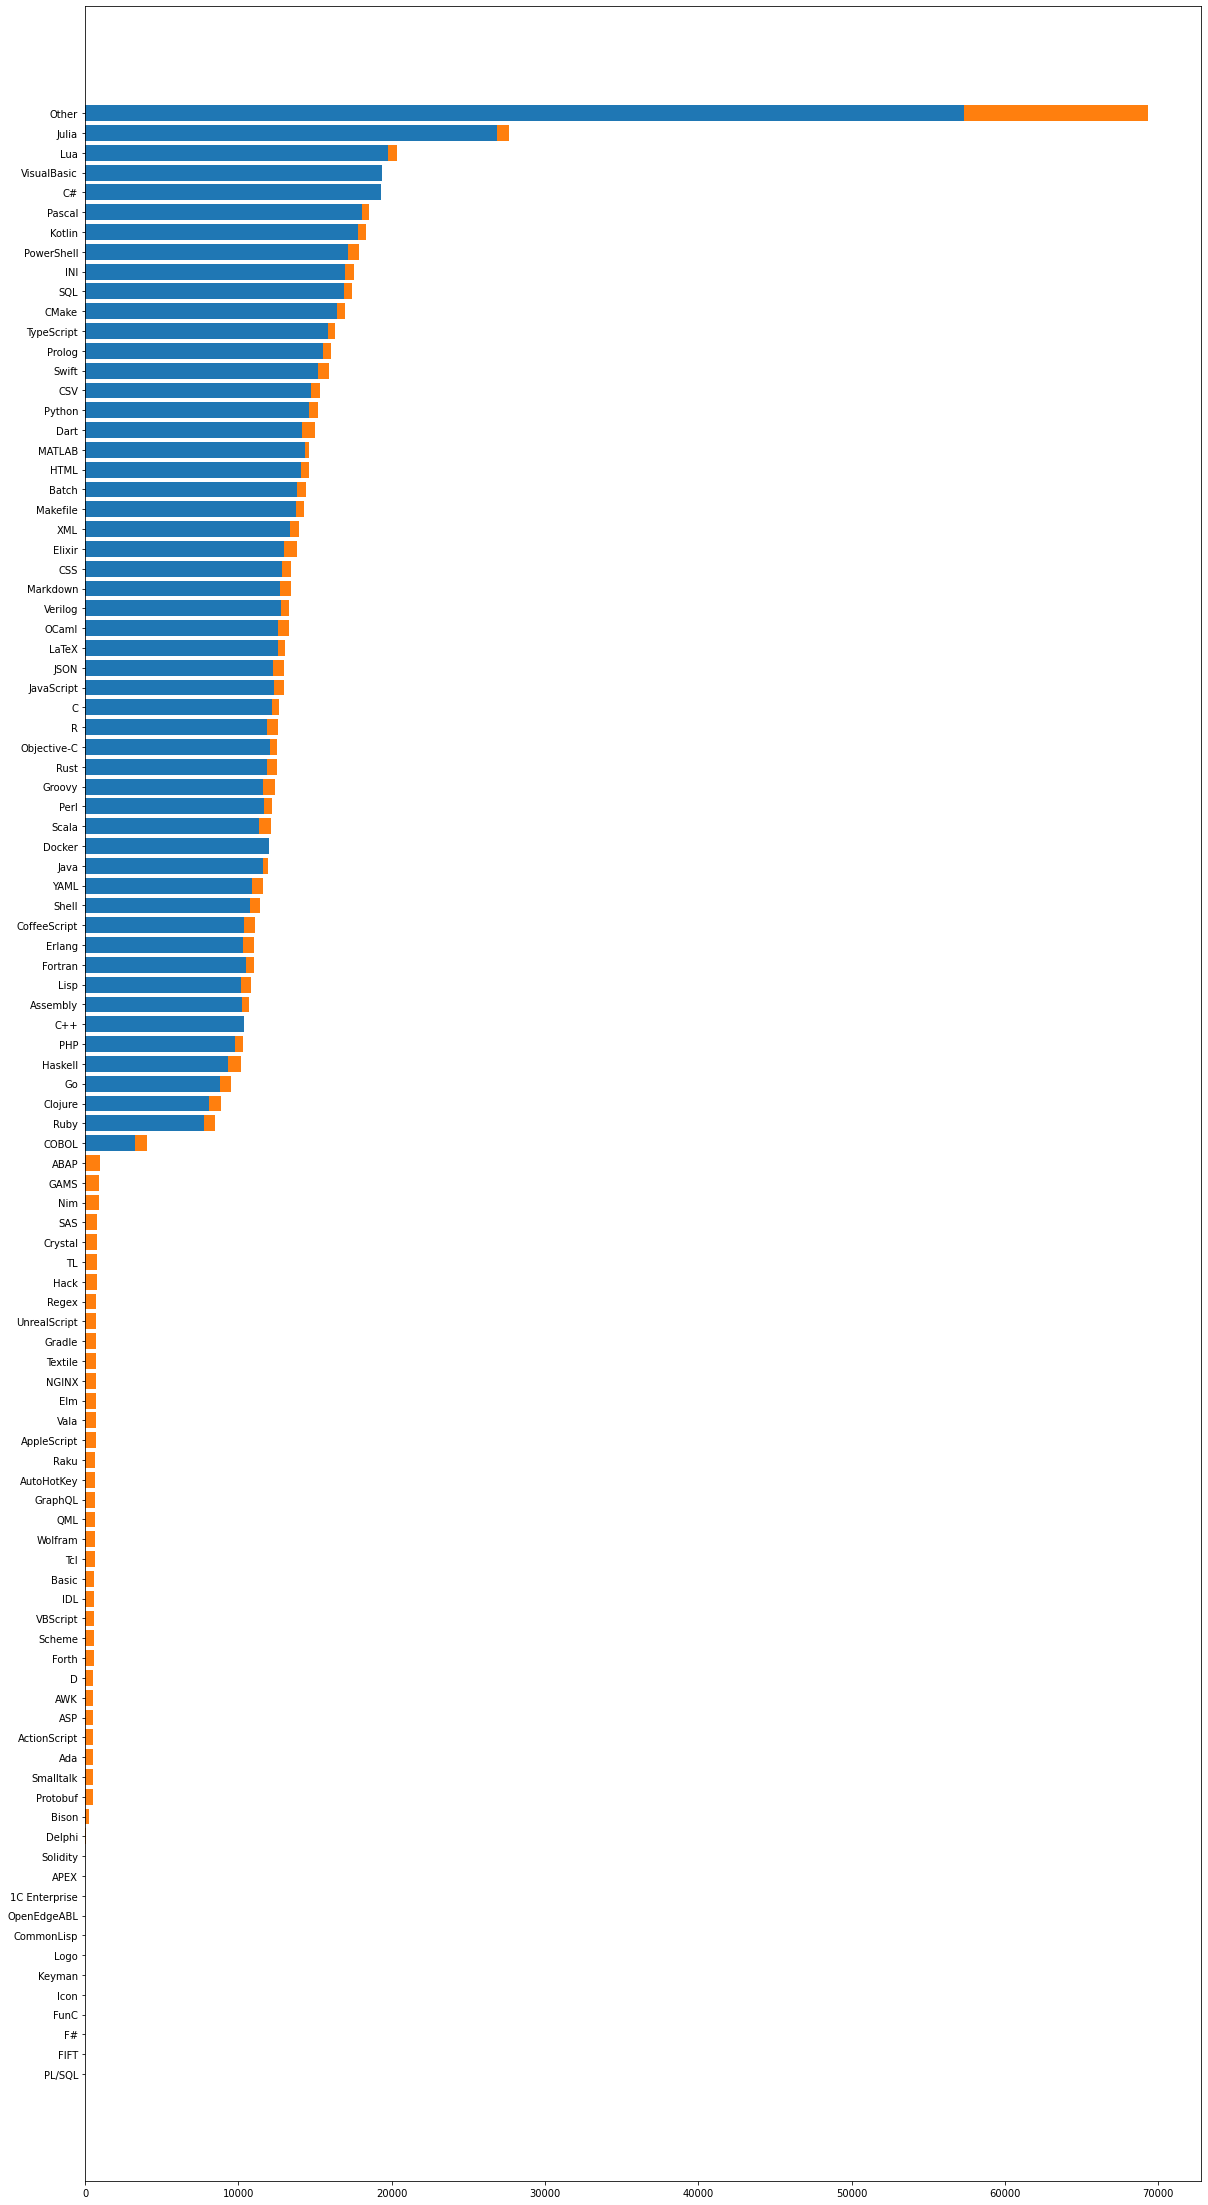

In [2]:
dataset1 = GLToolDataset()
dataset2 = GHDataset()

from collections import Counter
counts1 = Counter(dataset1.labels)
counts2 = Counter(dataset2.labels)

labels = [Languages.to_string(i+1) for i in range(100)]
occurences1 = np.array([counts1[Languages.from_string(label)] for label in labels])
occurences2 = np.array([counts2[Languages.from_string(label)] for label in labels])

order = np.argsort(occurences1 + occurences2)

plt.figure(figsize=[20, 40])
plt.barh(np.arange(100), occurences1[order])
plt.barh(np.arange(100), occurences2[order], left=occurences1[order])
plt.yticks(np.arange(100), np.array(labels)[order]);

In [2]:
dataset = MixedDataset(tokenize=True, subsample_lines=True)

In [ ]:
shuffle = np.arange(len(dataset))
labels = np.array([label.value - 1 for label in dataset.labels])
shuffle, fold0 = train_test_split(shuffle, stratify=labels[shuffle], test_size=200_000, random_state=42)
shuffle, fold1 = train_test_split(shuffle, stratify=labels[shuffle], test_size=200_000, random_state=43)
fold3, fold2 = train_test_split(shuffle, stratify=labels[shuffle], test_size=200_000, random_state=44)

with open("folds.pkl", "wb") as file:
   pickle.dump((fold0, fold1, fold2, fold3), file)

In [5]:
for i, fold in enumerate([fold0, fold1, fold2, fold3]):
    num_rows = len(fold)
    num_cols = 2**15

    data = []
    indices = []
    indptr = [0]

    for idx in tqdm.tqdm(fold):
        ids, label = dataset[idx]
        ids, counts = np.unique(ids, return_counts=True)
        data.extend(counts)
        indices.extend(ids)
        indptr.append(indptr[-1] + len(ids))

    sparse_data_matrix = csr_array((data, indices, indptr), shape=(num_rows, num_cols))
    save_npz(f"fold{i}.npz", sparse_data_matrix)
    del sparse_data_matrix

100%|██████████| 207101/207101 [05:01<00:00, 687.18it/s] 


In [2]:
with open("folds.pkl", "rb") as file:
   fold0, fold1, fold2, fold3 = pickle.load(file) 

In [4]:
# train_data = load_npz("fold0.npz")
val_data = load_npz("fold1.npz")

In [7]:
def normalize_sparse_mat(x):
    row_sum = x.sum(axis=1)
    x.data = x.data / np.repeat(row_sum, np.diff(x.indptr))
    return x

# train_data = normalize_sparse_mat(train_data)
val_data = normalize_sparse_mat(val_data)

In [10]:
labels = np.array([label.value - 1 for label in dataset.labels])

train_labels = labels[fold0]
val_labels = labels[fold1]

In [46]:
svc = LinearSVC(C=10, fit_intercept=False)
svc.fit(train_data, train_labels)
np.save("svc.npy", svc, allow_pickle=True)

LinearSVC(C=10, fit_intercept=False)

In [20]:
svc = np.load("svc.npy", allow_pickle=True).item()

In [21]:
predictions = svc.predict(val_data)
(val_labels == predictions).mean()

0.90922

In [49]:
minval = np.minimum(0, svc.coef_.min())

weights = np.ones((100, 2**15)) * minval
weights[np.unique(train_labels)] = svc.coef_
weights = np.pad(weights, ((0, 4), (0, 0)), constant_values=minval).T
weights = weights.astype(np.float32)

with open("solution/resources/svc_coefs.bin", "wb") as file:
    h, w = weights.shape
    file.write(h.to_bytes(4, "little"))
    file.write(w.to_bytes(4, "little"))

    file.write(weights.tobytes())

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

cm = confusion_matrix(val_labels, predictions, labels=list(range(len(Languages))))
classes = [
    Languages.to_string(Languages(i+1))
    for i in range(len(Languages))
]

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(40, 40), dpi=300)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if classes is not None:
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=90)
        plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm, classes)

In [40]:
cm.shape

(86, 86)

In [30]:
print(content)

[7, 10756, 371, 19052, 17, 8950, 9456, 203, 7, 5831, 371, 7221, 17, 5595, 17, 3354, 22, 203, 7, 4230, 30, 330, 18, 20, 203, 7, 10886, 371, 12068, 352, 88, 9712, 1069, 5526, 203, 7, 21492, 30, 1150, 413, 2977, 413, 1723, 394, 316, 13111, 9456, 14796, 518, 7, 742, 366, 413, 1423, 377, 7221, 2904, 2234, 11992, 22, 285, 17889, 1990, 2067, 21767, 504, 203, 7, 1519, 30, 487, 17, 9361, 17620, 203, 203, 203, 7, 1702, 2234, 894, 203, 8, 5726, 7385, 279, 1702, 17, 5019, 1600, 320, 2094, 2999, 1466, 13679, 805, 477, 361, 7116, 901, 731, 361, 3354, 22, 1122, 320, 22612, 29841, 31048, 492, 2625, 21247, 581, 16, 1992, 581, 16, 6410, 581, 16, 702, 16, 13768, 702, 16, 1935, 2063, 16, 5472, 1992, 16, 21899, 16, 21899, 21485, 87, 16, 2964, 16, 2964, 21485, 16, 4722, 308, 2519, 9779, 16, 3562, 636, 16, 3562, 636, 21485, 16, 3971, 702, 16, 5268, 16, 6410, 702, 16, 9735, 5667, 16, 3876, 702, 16, 22371, 13768, 702, 16, 3898, 16, 3898, 21485, 16, 6217, 702, 16, 1291, 11647, 16, 1677, 702, 16, 2308, 16, 1168,

In [36]:
tokenizer = ByteLevelBPETokenizer(
    "./tokenizer-vocab.json",
    "./tokenizer-merges.txt",
)

In [37]:
tokenizer.get_vocab_size()

32768

In [7]:
tokenizer.decode(ids)

'я веселый баклажан'

In [ ]:
data = Path.home() / "github_data"

paths = [
    [
        str(x) for x in lang_dir.glob("*")
    ] 
    for lang_dir in data.iterdir()
    if lang_dir.is_dir()
]
paths = list(chain(*paths))

In [9]:
# Initialize a tokenizer
tokenizer = ByteLevelBPETokenizer()

# Customize training
tokenizer.train(files=paths, vocab_size=2**15, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
], show_progress=True)

tokenizer.save_model(".", "tokenizer")

In [3]:
tokenizer.get_vocab()["<unk>"]

3

In [4]:
tokenizer.decode([193])

'\x00'

In [10]:
s = 'print("Hello, World!")'
encoding = tokenizer.encode("print('Hello, World!')")
# encoding = tokenizer.encode("Hell")

print(len(s), len(encoding.ids))
print(encoding.ids)
print([tokenizer.decode([id]) for id in encoding.ids])

22 7
[1196, 743, 12945, 16, 13712, 5, 1086]
['print', "('", 'Hello', ',', ' World', '!', "')"]


In [11]:
print([tokenizer.decode([id]) for id in [1196, 743, 12945, 16, 13712, 19417, 13]])

['print', "('", 'Hello', ',', ' World', "!'", ')']


In [42]:
max(len(token) for token in tokenizer.get_vocab().keys())

128

In [53]:
tokens, ids = zip(*tokenizer.get_vocab().items())
tokens = np.array(tokens)
ids = np.array(ids)

In [55]:
order = np.argsort(ids)
tokens = tokens[order]
ids = ids[order]

In [67]:
chr(288)

'Ġ'

In [94]:
tokens_bytes = []
lengths = []

for token, token_id in zip(tokens, ids):
    token_bytes = tokenizer.decode([token_id]).encode("utf-8")
    lengths.append(len(token_bytes))
    tokens_bytes.append(token_bytes)
    # break

In [101]:
lengths = np.array(lengths)

In [107]:
pointers = np.r_[0, (lengths + 1).cumsum()[:-1]]

In [113]:
len(tokens_bytes).to_bytes(length=4, signed=False, byteorder="little")

b'\x00\x80\x00\x00'

In [121]:

with open("tokenizer_vocab.bin", "wb") as file:
    n_tokens = len(tokens_bytes)
    sum_len = (lengths + 1).sum()

    file.write(n_tokens.to_bytes(length=4, signed=False, byteorder="little"))
    file.write(int(sum_len).to_bytes(length=4, signed=False, byteorder="little"))
    
    for offset in pointers:
        file.write(int(offset).to_bytes(length=8, signed=False, byteorder="little"))
        
    for token_bytes in tokens_bytes:
        file.write(token_bytes)
        file.write(b"\0")

In [128]:
tokenizer.encode("H").ids

[44]

In [120]:
tokens[-1]

'10010'

In [82]:
tokenizer.encode('ĠHello, world').ids

[133, 259, 12945, 16, 8044]

In [99]:
tokens_bytes[133]

b'\xef\xbf\xbd'

In [83]:
[
    tokenizer.decode([token_id])
    for token_id in tokenizer.encode('ĠHello, world').ids
]

['�', '�', 'Hello', ',', ' world']

In [74]:
list(token_bytes)

[60, 115, 62]

In [43]:
tokenizer.get_vocab_size()

32768

In [39]:
for id in tokenizer.encode("кек").ids:
    print(tokenizer.decode([id]))

к
ек


In [35]:
tokenizer.decode([225]).encode("utf8")[0]

32

In [ ]:
import torch
from torch import nn

model = nn.Sequential(
    nn.Embedding()
)

In [29]:
for id in encoding.ids:
    print(tokenizer.decode([id]))

print
("
Hello
,
 World
!")
